In [14]:
import bionumpy as bnp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import Tuple, Dict
import pickle
import gzip
from bionumpy.encoded_array import EncodedArray, EncodedRaggedArray, as_encoded_array
from collections import Counter


In [2]:
def extract_motif_flanked_sequences(raw_sequence, left_motif, right_motif, 
                                    left_search_start=11, right_search_start=47, 
                                    window_size=12, sequence_length=150):
    """
    Extracts sequences between left and right motifs from a Bionumpy EncodedRaggedArray.
    
    Parameters:
    ----------
    raw_sequence : EncodedRaggedArray
        Full-length nucleotide sequences.
    left_motif : EncodedArray or str
        The motif to search on the left side (e.g., "ATGCAT").
    right_motif : EncodedArray or str
        The motif to search on the right side (e.g., "CAATTG").
    left_search_start : int
        Start position for left motif search in the input sequence.
    right_search_start : int
        Start position for right motif search in the input sequence.
    window_size : int
        Size of the motif search window (default 12).
    sequence_length : int
        Length of each row in the raw_sequence (default 150).
        
    Returns:
    -------
    EncodedRaggedArray
        Sliced sequences between motif hits.
    """
    if isinstance(left_motif, str):
        left_motif = as_encoded_array(left_motif)
    if isinstance(right_motif, str):
        right_motif = as_encoded_array(right_motif)

    N = len(raw_sequence)

    # Step 1: match motifs in specified windows
    left_match_pos  = bnp.match_string(raw_sequence[:, left_search_start:left_search_start+window_size], left_motif)
    right_match_pos = bnp.match_string(raw_sequence[:, right_search_start:right_search_start+window_size], right_motif)

    left_match_dense  = left_match_pos.ravel().reshape(N, 7)
    right_match_dense = right_match_pos.ravel().reshape(N, 7)

    # Step 2: select rows with exactly one hit on both sides
    left_hits  = left_match_dense.sum(axis=1)
    right_hits = right_match_dense.sum(axis=1)
    valid_rows = (left_hits == 1) & (right_hits == 1)

    # Step 3: get offsets for exact match positions
    left_offset  = np.argmax(left_match_dense[valid_rows],  axis=1)
    right_offset = np.argmax(right_match_dense[valid_rows], axis=1)

    left_pos  = left_search_start + 6 + left_offset # +6 turn 11 into 17, from the left end to the right end
    right_pos = right_search_start + right_offset

    # Step 4: create mask for slicing
    cols = np.arange(sequence_length)
    mask = (cols >= left_pos[:, None]) & (cols < right_pos[:, None])

    subset = raw_sequence[valid_rows]
    flat = subset.raw()
    seq_2d = flat.ravel().reshape(len(subset), sequence_length)

    sliced = [row[m] for row, m in zip(seq_2d, mask)]

    lengths = np.fromiter((len(r) for r in sliced), dtype=np.int32)
    flat_concat = np.concatenate(sliced)
    encoding = raw_sequence.encoding

    return EncodedRaggedArray(
        EncodedArray(flat_concat, encoding),
        lengths
    )


In [3]:
barcodeLibrary_folder = "/home/zhouwan2/expansion_link/RNA_seq_raw_data/cseq1_virus_lib_072825/"
bar_fastq = ["171m_AGGCAGAA-GTGTAGAT_L001_R2_001.fastq.gz", "253m_TAAGGCGA-GTGTAGAT_L001_R2_001.fastq.gz", "266m_CGTACTAG-GTGTAGAT_L001_R2_001.fastq.gz"]
bar_data = []
for bar in bar_fastq:
    f = bnp.open(barcodeLibrary_folder+bar)
    bar_data.append(f.read())

In [4]:
print(bar_data)

[SequenceEntryWithQuality with 55319109 entries
                     name                 sequence                  quality
  LH00285:194:232KJVLT3:1  GCCTGAGATTGCAGATGCATTAC  [40 40 40 40 40 40 40 4
  LH00285:194:232KJVLT3:1  GCCTGAGAGCGCAGATGCATGGA  [40 40 40 40 40 40 40 4
  LH00285:194:232KJVLT3:1  GCCTGAGAGTGCAGATGCATTGC  [40 40 40 40 40 40 40 4
  LH00285:194:232KJVLT3:1  GCCTGAGAGTGCAGATGCATCTC  [40 40 40 40 40 40 40 4
  LH00285:194:232KJVLT3:1  GCCTGAGAGTGCAGATGCATGGC  [40 40 40 40 40 40 40 4
  LH00285:194:232KJVLT3:1  GCCTGAGAGTGCAGATGCATTAT  [40 40 40 40 40 40 40 4
  LH00285:194:232KJVLT3:1  GCCTGAGAGCGCAGATGCATTTT  [40 40 40 40 40 40 40 4
  LH00285:194:232KJVLT3:1  GCCTGAGAGCGCAGATGCATGGC  [40 40 40 40 40 40 40 4
  LH00285:194:232KJVLT3:1  GCCTGAGATCGCAGATGCATGAC  [40 40 40 40 40 40 40 4
  LH00285:194:232KJVLT3:1  GCCTGAGAGTGCAGATGCATCTA  [40 40 40 40 40 40 40 4, SequenceEntryWithQuality with 56181870 entries
                     name                 sequence                  

In [5]:
motif_1 = as_encoded_array("ATGCAT") # left matching sequence for post virus/ right matching sequence for pre virus
motif_2 = as_encoded_array("CAATTG") # right matching sequence for post virus/ right matching sequence for pre virus

In [6]:
bar_seq = [i.sequence for i in bar_data]

In [7]:
barcode_171m = extract_motif_flanked_sequences(bar_seq[0], motif_1, motif_2)
barcode_253m = extract_motif_flanked_sequences(bar_seq[1], motif_2, motif_1)
barcode_266m = extract_motif_flanked_sequences(bar_seq[2], motif_2, motif_1)

In [8]:
def collapse_barcodes(
    encoded_ra,
    length: int = 30,
    plot: bool = False
) -> Tuple[pd.DataFrame, Dict[str, float]]:
    """
    Collapse identical fixed-length sequences in a BioNumPy EncodedRaggedArray
    and compute basic diversity statistics.

    Parameters
    ----------
    encoded_ra : bionumpy.EncodedRaggedArray
        The input reads.
    length : int, default 30
        Only rows whose length equals this value are kept.
    plot : bool, default False
        If True, show a histogram of read counts per unique barcode.

    Returns
    -------
    df : pandas.DataFrame
        Columns: 'barcode' (string) and 'count' (int), one row per unique barcode.
    stats : dict
        Keys: 'total_reads', 'num_unique', 'prop_unique',
              'shannon_H', 'gini_index'.
    """
    # ── 1. filter rows of desired length ───────────────────────────────
    mask_fixed = encoded_ra.lengths == length
    fixed_reads = encoded_ra[mask_fixed]

    if len(fixed_reads) == 0:
        raise ValueError(f"No reads of length {length} found.")

    # ── 2. zero-copy view to (N, L) uint8 matrix ───────────────────────
    flat = fixed_reads.raw()                      # 1-D uint8
    seq2d = flat.ravel().reshape(len(fixed_reads), length)

    # ── 3. reinterpret each row as a single bytes object ───────────────
    bytes_per_row = seq2d.view(f'|S{length}').ravel()

    # ── 4. collapse & count duplicates ────────────────────────────────
    uniq, counts = np.unique(bytes_per_row, return_counts=True)
    uniq_str = uniq.astype(f'U{length}')          # decode to text

    # ── 5. diversity statistics ───────────────────────────────────────
    total = counts.sum()
    num_unique = len(uniq)
    freq = counts / total

    stats = {
        "total_reads" : int(total),
        "num_unique"  : int(num_unique),
        "prop_unique" : num_unique / total,
        "shannon_H"   : float(-(freq * np.log2(freq)).sum()),
        "gini_index"  : float(1 - (counts ** 2).sum() / total ** 2),
    }

    # ── 6. optional plot ───────────────────────────────────────────────
    if plot:
        plt.hist(counts, bins="auto", log=True)
        plt.xlabel("Read count per barcode")
        plt.ylabel("Number of barcodes")
        plt.title(f"Barcode abundance distribution (L={length})")
        plt.show()

    # ── 7. build DataFrame and return ─────────────────────────────────
    df = pd.DataFrame({"barcode": uniq_str, "count": counts})
    return df, stats


In [9]:
barcode_171m

encoded_ragged_array(['TACCAATCTACGTCCGCTGCATGAACCTTT',
                      'GGACACACTATATGCTAGACATCGTCAATC',
                      'TGCACAGTTACGAAGGCTATATTGTCGCGG',
                      'CTCAAATCTATGACCCCATGATGTACCCGT',
...
                      'GGCCGATTTACTAGCCGCTTATCACAACGC'])

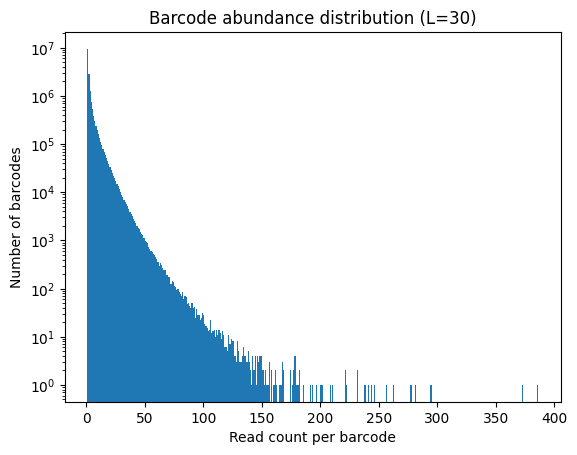

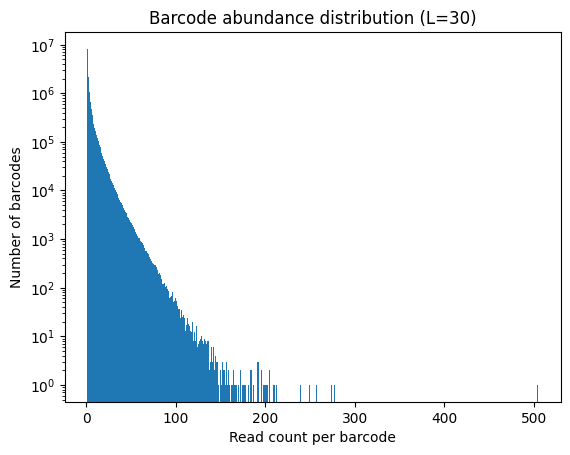

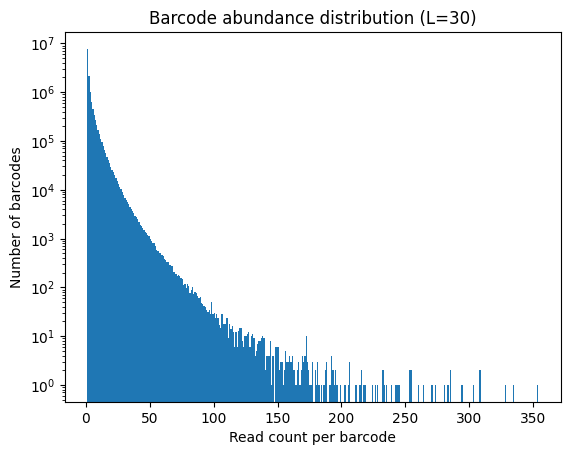

{'total_reads': 51880604, 'num_unique': 17113651, 'prop_unique': np.float64(0.32986607095013776), 'shannon_H': 23.15542591683304, 'gini_index': 0.9999998025071221}


,barcode,count
0,AAAAAAGCTACGCGCTGATCATCACGCCTG,1
1,AAAAAAGCTACGTCGACAACATTGCACAGC,1
2,AAAAAAGGTAGATCTGGCTTATGGTGCAGT,1
3,AAAAACATTAGACCAACCGTATCTTGGCTT,1
4,AAAAACGATACACCTCACCAACTTCCCCCC,1


In [10]:
df_171, stats_171 = collapse_barcodes(barcode_171m, length=30, plot=True)
df_253, stats_253 = collapse_barcodes(barcode_253m, length=30, plot=True)
df_266, stats_266 = collapse_barcodes(barcode_266m, length=30, plot=True)

print(stats_171)
# {'total_reads': 50000000, 'num_unique': 3624512, ...}

df_171.head()


In [15]:
df_171.to_csv("/home/zhouwan2/expansion_link/RNA_seq_processed_data/cseq1_virus_lib_results_080325/barcode_count_171m.csv", index=False)
df_253.to_csv("/home/zhouwan2/expansion_link/RNA_seq_processed_data/cseq1_virus_lib_results_080325/barcode_count_253m.csv", index=False)
df_266.to_csv("/home/zhouwan2/expansion_link/RNA_seq_processed_data/cseq1_virus_lib_results_080325/barcode_count_266m.csv", index=False)


In [28]:
counts_171 = df_171["count"].to_numpy()
F_171 = Counter(counts_171)          # F_k spectrum
N_sample  = counts_171.sum()     # here 50_000_000

with open('/home/zhouwan2/expansion_link/RNA_seq_processed_data/cseq1_virus_lib_results_080325/hist_171m.txt', 'w') as fh:
    for k in sorted(F_171):
        fh.write(f"{k}\t{F_171[k]}\n")       #  “count” \t “how many such counts”

In [29]:
counts_253 = df_253["count"].to_numpy()
F_253 = Counter(counts_253)          # F_k spectrum
N_sample  = counts_253.sum()     # here 50_000_000

with open('/home/zhouwan2/expansion_link/RNA_seq_processed_data/cseq1_virus_lib_results_080325/hist_253m.txt', 'w') as fh:
    for k in sorted(F_253):
        fh.write(f"{k}\t{F_253[k]}\n")       #  “count” \t “how many such counts”

In [30]:
counts_266 = df_266["count"].to_numpy()
F_266 = Counter(counts_266)          # F_k spectrum
N_sample  = counts_266.sum()     # here 50_000_000

with open('/home/zhouwan2/expansion_link/RNA_seq_processed_data/cseq1_virus_lib_results_080325/hist_266m.txt', 'w') as fh:
    for k in sorted(F_266):
        fh.write(f"{k}\t{F_266[k]}\n")       #  “count” \t “how many such counts”

In [35]:
import pandas as pd
import numpy as np

# 1 ── read the file, letting pandas keep only the two numeric columns
curve = (
    pd.read_csv(
        '/home/zhouwan2/expansion_link/RNA_seq_processed_data/'
        'cseq1_virus_lib_results_080325/complexity_171m.txt',
        sep=r'\s+',          # any amount of whitespace
        comment='#',         # ignore header lines that start with '#'
        header=None,         # no header row in the data area
        names=['D', 'U'],    # total reads, unique reads
        usecols=[0, 1],      # ignore accidental extra tokens
    )
    .apply(pd.to_numeric, errors='coerce')   # turn strings → floats, bad → NaN
    .dropna()                                # drop non-numeric rows
    .sort_values('D')                        # make sure D is increasing
)

# 2 ── interpolate
target_depth = 10_000_000_00   # 10 G
U_10G   = np.interp(target_depth, curve['D'].values, curve['U'].values)
dup_rate = 1 - U_10G / target_depth
print(f"Predicted duplication rate at 10 G reads: {dup_rate:.10%}")


Predicted duplication rate at 10 G reads: 94.7977961700%
